# GAIA Clustering and Get ilabel
#### -------------------------------------------------------------------------
## Data importation from **.vot

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.cluster import DBSCAN
from sklearn import cluster

import sys, os
sys.path.append('C:\\Users\Quentin\\Documents\\ALMA_CHILI\\gaia-shock\\src')

## directory
rootdir = r'C:\Users\Quentin\Documents\ALMA_CHILI'
wdir    = r'%s\products'%(rootdir)
#notedir = r'%s\gaia-shock\notebooks_Quentin'%(rootdir)

os.chdir(wdir)  # to change the current directory

import gaia_utils_quentin as gu

In [2]:
voname_list = ["NGC2682-4.0deg-0.2err.vot", "NGC2516-3.5deg-0.2err.vot", "NGC2516-6.0deg-0.2err.vot","NGC6811-1.0deg-0.2err.vot", "NGC1039-3.0deg-0.1err.vot",
               "NGC1647-4.0deg-0.2err.vot", "Collinder65-4.0deg-0.2err.vot", "NGC1647-3.0deg-0.1err.vot"]

voname  = voname_list[0]
weight  = [5,1,1,4,4,4,4,4]
WEIGHT  = [10.7, 6.5, 6.5, 4.1, 4.1, 2.1, 2.1, 2.1]

with open('ilabel_dbscan', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    file_result = my_depickler.load()

In [14]:
for name in file_result :
    print(name)

NGC2682
NGC2516
NGC6811
NGC1647


In [60]:
for source in tab_source :
    print(source.errtol)

0.01
0.02
0.03
0.2


In [43]:
#tab_source = []
for voname in ["NGC2516-6.0deg-0.2err.vot"] :
    source = gu.source()
    source.read_votable(voname)
    source.convert_filter_data()
    source.convert_to_cartesian()
    tab_source.append(source)

## NGC2516-6.0deg-0.2err.vot read...
## Total stars: 80414
## Density star per pc^3: 0.03218

## Conversion on 80414 stars done...
## Stars selected: 78782



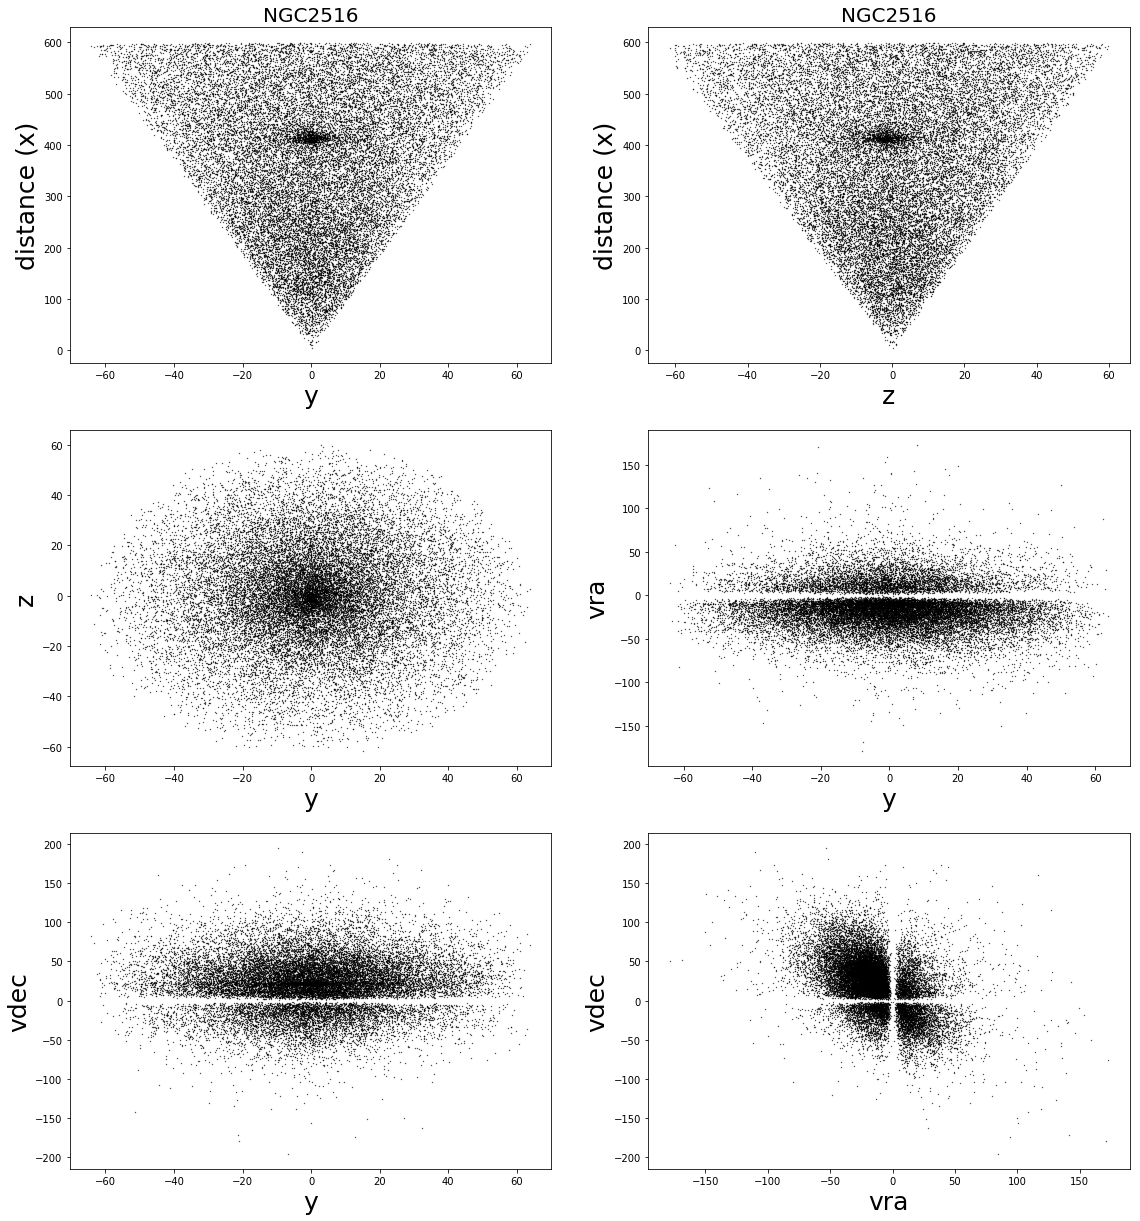

In [7]:
source.plot_information(0.1,True,ilabel=[],HRD=False)
#source.plot_information(0.001,False,ilabel=file_result[source.name]['ilabel'])

#### -------------------------------------------------------------------------

In [72]:
def save_ilabel(source, ilabel, eps, min_samples) :
    "Save ilabel found with dbscan(eps,min_samples,weight) from cluster 'source'"
    
    with open('ilabel_dbscan', 'rb') as fichier:
        my_depickler = pickle.Unpickler(fichier)
        file_result = my_depickler.load()
        
    # select data in cartesian from ilabel
    if source.dfcart is None :
        data_cart = gu.convert_to_cartesian(source.df[ilabel,:])
    else :
        data_cart = source.dfcart[ilabel,:]

    name = "%s_%s"%(source.name,source.errtol)
    
    if name not in file_result :
        file_result[name] = {}
    else :
        file_result.pop(name)
        
    ifinal = source.unmasked
    parallax_err = np.array(source.data['parallax_error'][ifinal])
    dist_err = source.dfcart[:,0]**2 * parallax_err / 1000

    file_result[name] = {}
    file_result[name]['eps_min_samples'] = (eps,min_samples)
    file_result[name]['weight'] = source.weight
    file_result[name]['data_cart'] = data_cart
    file_result[name]['dist_err'] = dist_err[ilabel]
    file_result[name]['ilabel'] = ilabel
    file_result[name]['density'] = source.density

    with open('ilabel_dbscan', 'wb') as fichier:
        my_pickler = pickle.Pickler(fichier)
        my_pickler.dump(file_result)

In [64]:
##############################################
def dbscan_labels(data, eps=0.15, min_samples=15, all_labels=False, display=True) :
    "Compte a DBSCAN clustering and return the largest cluster found"

    ts = time.clock()
    db = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters_ > 0 :
        max_size = 0
        total_labels = []
        for i in range(n_clusters_) :
            ilabel = np.where(labels == i)[0]
            total_labels.append(ilabel)
            label_size = len(ilabel)
            if label_size > max_size :
                ilabel_final = np.copy(ilabel)
                max_size = label_size
        if all_labels : result = total_labels
        else          : result = ilabel_final
        if display :
            print("## %d clusters, size of the largest: %d  (on %d stars : %.1f%%)"%(n_clusters_,len(ilabel_final),len(data[:,1]),100*len(ilabel_final)/len(data[:,1])))
            tf = time.clock() - ts
            if tf//60 == 0 : string = "%.1fs"%(tf%60)
            else : string = "%dmin %.1fs"%(tf//60,tf%60)
            print("## Execution time : "+string)
        return result
    else :
        print("ERROR 0 cluster found with eps="+str(eps)+" and min_samples="+str(min_samples))
        return []


#### -------------------------------------------------------------------------
## DBSCAN Clustering

In [6]:
#save_ilabel(source,file_result_DAM[source.name]['ilabel'],file_result_DAM[source.name]['eps_min_samples'][0],file_result_DAM[source.name]['eps_min_samples'][1])

In [15]:
weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
WEIGHT  = [10.7, 6.5, 6.5, 4.1, 4.1, 2.1, 2.1, 2.1]
source.set_weight(weight)
source.normalization_normal()
#print(file_result["NGC2516"]['density'])
#print(source.density)

## Normalization done on filtered data..


In [19]:
print(file_result["NGC2516"]['eps_min_samples'])
print(source.distmax)

(1.4, 20)
800.0


In [55]:
eps=1.7
min_samples=20
ilabel_ = source.dbscan_labels(eps, min_samples, all_labels=True, display=True)
#save_ilabel(source, ilabel_[0], eps, min_samples)

## 1 clusters, size of the largest: 2801  (on 44723 stars : 6.3%)
## Execution time : 4.8s


In [50]:
for i, ilabel in enumerate(ilabel_):
    #a = np.zeros(source.df.shape[0])
    #a[ilabel] = 1
    #ii = np.where(a==0)[0]
    #gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
    #gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
    print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

## 0, 2801 stars, Dist : 414.5, Max Dist : 165.9 and 39.4


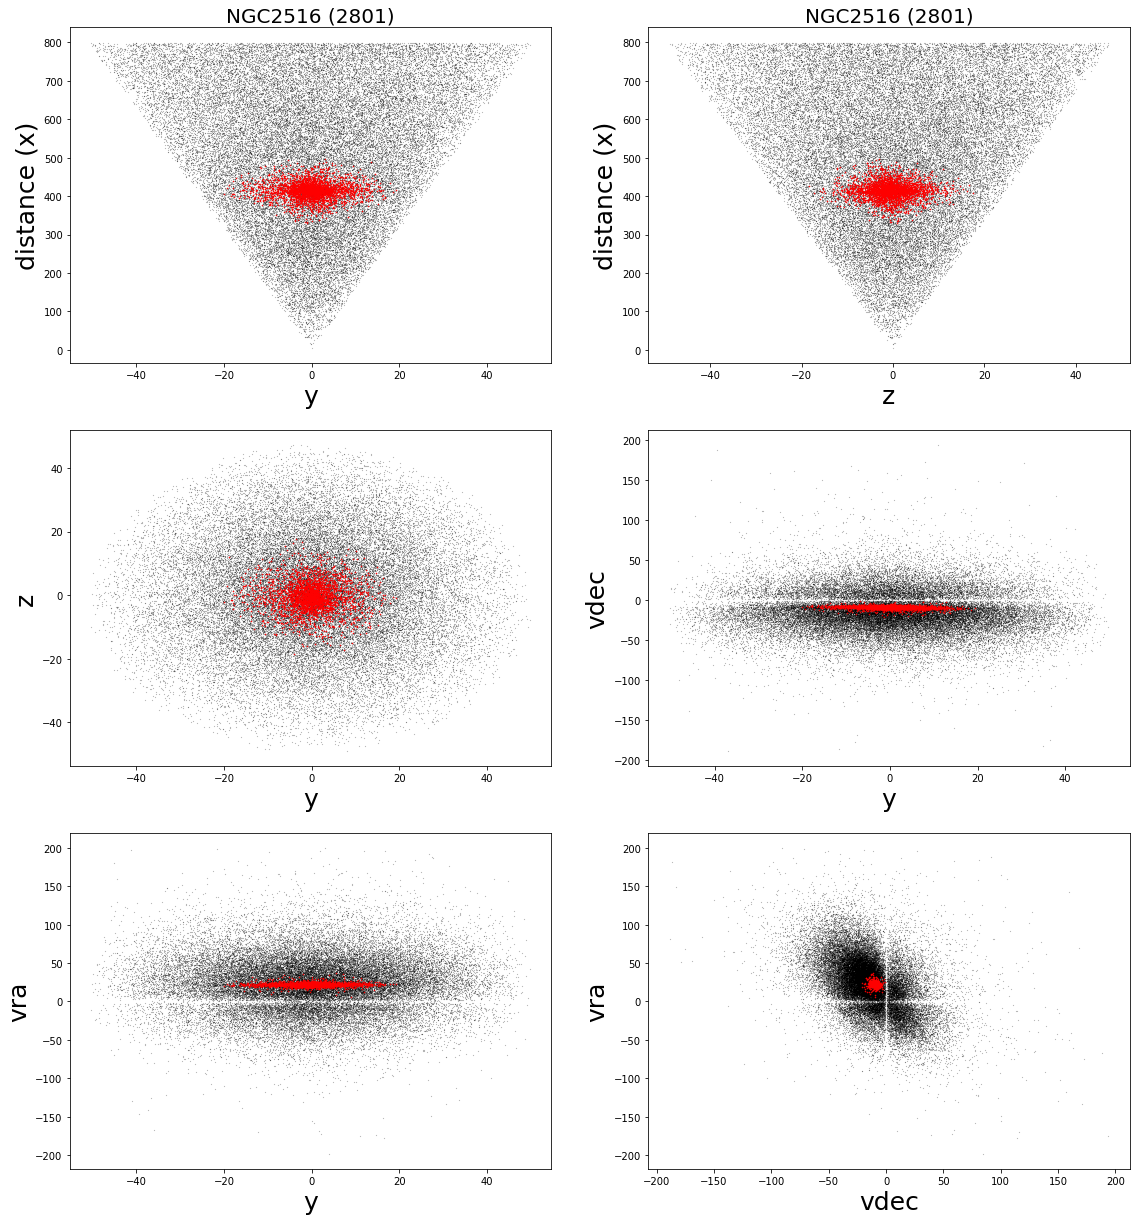

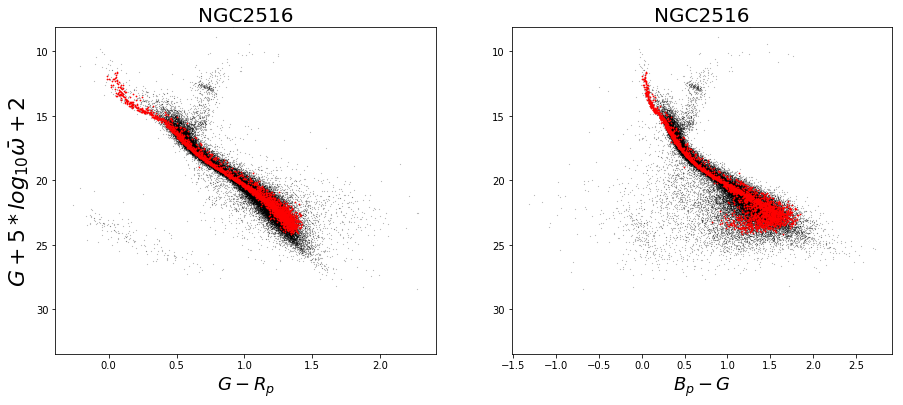

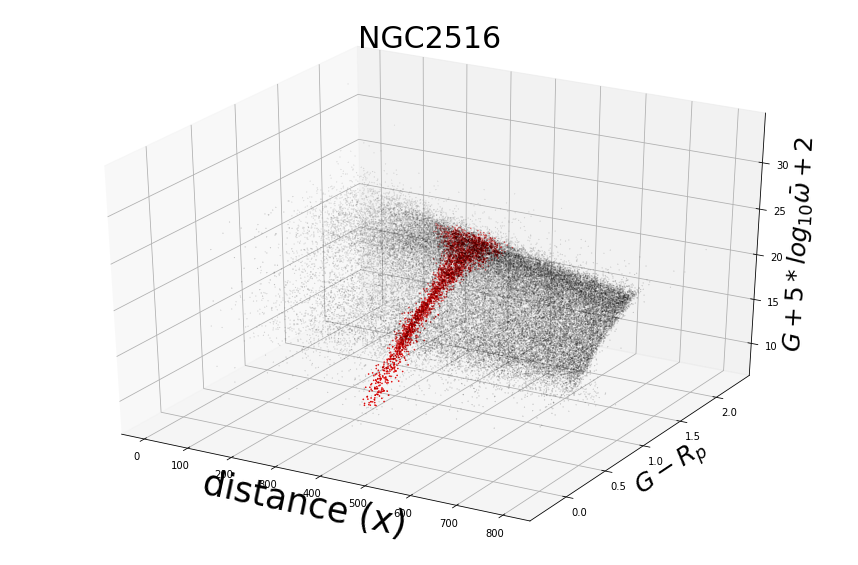

In [51]:
for ilabel in ilabel_ :
    #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
    source.plot_information(0.01,True, HRD=True, ilabel=ilabel)
    source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)

#### ------------------------------------------------------------------------
## Finding the best $eps$ and $min\_samples$

In [80]:
# #############################################################################
# Compute DBSCAN
ts = time.clock()
eps_ = [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3]
min_samples_ = [10,15,20,25,30,40,50,60]
mat_nb_clusters = np.zeros((len(eps_),len(min_samples_)))
mat_max = np.zeros((len(eps_),len(min_samples_)))
for i in range(len(eps_)) :
    for j in range(len(min_samples_)) :
        db = DBSCAN(eps=eps_[i], min_samples=min_samples_[j]).fit(dfnormcart)
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        mat_nb_clusters[i,j] = n_clusters_
        max_label = 0
        for n in range(n_clusters_) :
            ilabel = np.where(labels == n)[0]
            if len(ilabel) > max_label :
                max_label = len(ilabel)
                #max_label = len(ilabel)/np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])
        mat_max[i,j] = max_label
        #print("Ok pour eps "+str(eps_[i])+" et min_samples="+str(min_samples_[j]))
tf = time.clock() - ts
if tf//60 == 0 : string = "%.1fs"%(tf%60)
else : string = "%dmin %.1fs"%(tf//60,tf%60)
print("## Execution time : "+string)

## Execution time : 20.9s


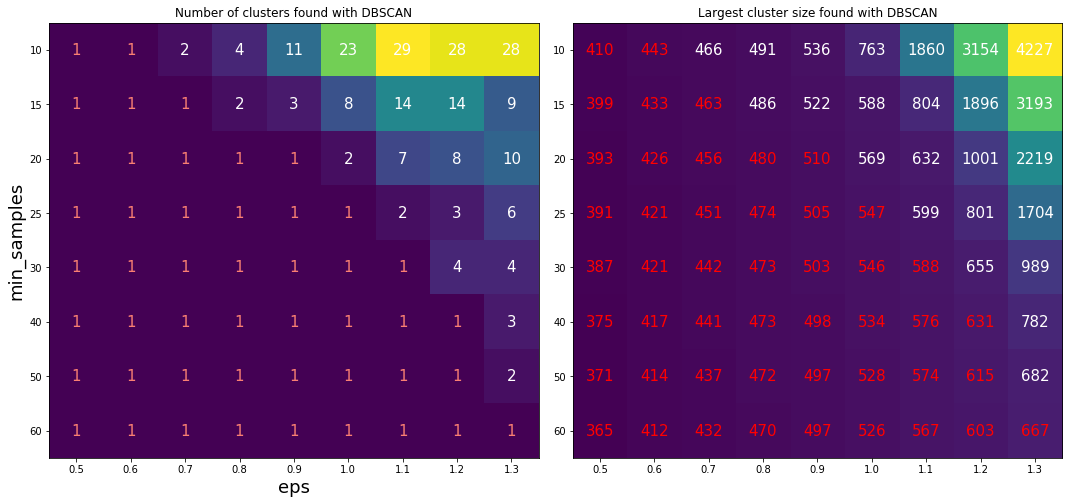

In [81]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(15,15))

im = ax.imshow(mat_nb_clusters.T)
ax.set_xticks(np.arange(len(eps_)))
ax.set_yticks(np.arange(len(min_samples_)))
ax.set_xticklabels(eps_)
ax.set_yticklabels(min_samples_)
# Loop over data dimensions and create text annotations.
for i in range(len(eps_)):
    for j in range(len(min_samples_)):
        if mat_nb_clusters[i, j] == 1 : color = "salmon"
        else : color = "w" 
        text = ax.text(i, j, '%d'%mat_nb_clusters[i, j],
                       ha="center", va="center", color=color, fontproperties='bold', fontsize=15)
ax.set_title("Number of clusters found with DBSCAN")
ax.set_xlabel("eps", fontsize = 18)
ax.set_ylabel("min_samples", fontsize = 18)
fig.tight_layout()

im = ax2.imshow(mat_max.T)
ax2.set_xticks(np.arange(len(eps_)))
ax2.set_yticks(np.arange(len(min_samples_)))
ax2.set_xticklabels(eps_)
ax2.set_yticklabels(min_samples_)
# Loop over data dimensions and create text annotations.
for i in range(len(eps_)):
    for j in range(len(min_samples_)):
        if mat_nb_clusters[i, j] == 1 : color = "r"
        else : color = "w" 
        text = ax2.text(i, j, '%d'%mat_max[i, j], ha="center", va="center", color=color, fontsize=15)
ax2.set_title("Largest cluster size found with DBSCAN")
ax.set_xlabel("eps", fontsize = 18)
ax.set_ylabel("min_samples", fontsize = 18)
fig.tight_layout()

plt.savefig('NGC6811_.png')
plt.show()

#### -------------------------------------------------------------------------

In [79]:
source = tab_source[0]
tab_eps = np.linspace(0.3,1.3,10)
min_samples = 30
label_pre = []
result = []
ts = time.clock()

for eps in tab_eps :
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(dfnormcart)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    big_label = np.where(labels == 0)[0]
    for n in range(1,n_clusters) :
        ilabel = np.where(labels == n)[0]
        if len(ilabel) > len(big_label) :
            big_label = ilabel
       
    if len(label_pre) < len(big_label) :
        label_pre = big_label
        result.append((big_label,eps))
    
tf = time.clock() - ts
if tf//60 == 0 : string = "%.1fs"%(tf%60)
else : string = "%dmin %.1fs"%(tf//60,tf%60)
print(string)

42.8s


In [80]:
x = []; s = []; y0 = []
y = {}
for i in range(8) :
    y[i] = []
    
for label in result :
    x.append(label[1])
    #s.append(len(label[0]))
    s.append(np.sqrt(np.mean(np.linalg.norm(source.dfcart[label[0],:3] - np.mean(source.dfcart[label[0],:3],axis=0))**2))/len(label[0])**2)
    for i in range(8) :
        y[i].append(np.std(source.dfcart[label[0],i]))
    y0.append( np.sqrt(np.mean(np.linalg.norm(source.dfcart[label[0],:3] - np.mean(source.dfcart[label[0],:3],axis=0))**2)) )

IndexError: index 33365 is out of bounds for axis 0 with size 11390

In [ ]:
plt.figure(figsize=(17,6))
plt.subplot(131)
for i in range(0,5) : 
    plt.plot(x,y[i],label=gu.data_name_cart[i])
plt.legend(loc=0)
plt.subplot(132)
plt.plot(x,y0,label='3d')
plt.legend(loc=0)
plt.subplot(133)
plt.plot(x[20:],s[20:],label='rapport')
plt.legend(loc=0)
plt.show()

In [ ]:
loc_min = []
exponant = np.linspace(0.5,5,50)
for exp in exponant :
#for exp in [2.0] :
    x = []; s = []
    for label in result :
        x.append(label[1])
        #s.append(len(label[0]))
        s.append(np.sqrt(np.mean(np.linalg.norm(source.dfcart[label[0],:3] - np.mean(source.dfcart[label[0],:3],axis=0))**2))/len(label[0])**exp)
    print(x[np.argmin(s[:200])])
    loc_min.append(x[np.argmin(s[:200])])
    plt.figure(figsize=(12,3))
    plt.plot(x[20:],s[20:],label='rapport')
    plt.scatter(x[np.argmin(s[:200])],min(s[:200]),c='r',s=40)
    plt.legend(loc=0)
    plt.title(exp)
    plt.show()

In [ ]:
plt.plot(exponant,loc_min)
plt.show()

## -------------------------------------------------

In [11]:
a = []
for i in range(8) :
    dist = np.sort(source.dfcart[:,i])
    distm = dist[1:] - dist[:-1]
    a.append(np.mean(distm))
a = np.array(a)
print(a*1000)
print(1/a)
div = [15,8,0.5,0.07]

[24.95616913  5.36191234  5.08807269 14.72495923 16.33957355  0.99576171
  0.11059028  0.14162818]
[  40.07025255  186.50062455  196.53807253   67.91190281   61.20110765
 1004.25632861 9042.38589553 7060.74172254]


In [67]:
a = []
for i in range(8) :
    dist = np.sort(source2.dfcart[:,i])
    distm = dist[1:] - dist[:-1]
    a.append(np.mean(distm))
a = np.array(a)
print(a*1000)
print(1/a)
div = [15,8,0.5,0.07]

[52.19365368 11.21885929 10.49950993 27.84697657 31.65082113  2.00536881
  0.21025291  0.28285315]
[  19.15941747   89.13562188   95.24254051   35.91054122   31.59475692
  498.66139162 4756.17682183 3535.40339702]


In [12]:
def lissage(x,y,p):
    "smoothing y data computing the Moving average"
    Lyout=[]; Lxout = np.copy(x[p: -p])
    for index in range(p, len(y)-p):
        Lyout.append(np.mean(y[index-p : index+p+1]))
    return Lxout,Lyout

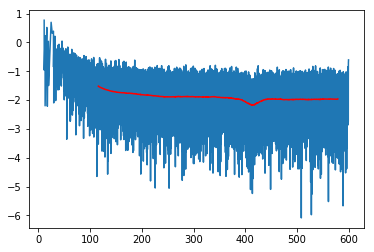

0.024956169134300637


In [13]:
dist = np.sort(source.dfcart[:,0])
distm = dist[1:] - dist[:-1]  
x, y = lissage(dist[1:],np.log10(distm), 1000)
plt.plot(dist[1:],np.log10(distm))
plt.plot(x,y,c='r')
plt.show()
print(np.mean(distm))

## ------------------------------------------------------------
### Loop to get all votable in the list

In [308]:
voname_list = ["NGC2682-4.0deg-0.2err.vot", "NGC2516-6.0deg-0.2err.vot", "NGC1647-4.0deg-0.2err.vot", "NGC6811-1.0deg-0.2err.vot"]
#tab_source = []
tab_ilabel = []
for voname in [voname_list[-1]] :
    source = gu.source()
    source.read_votable(voname)
    source.convert_filter_data()
    source.convert_to_cartesian()
    tab_source.append(source)
    
    ilabel = file_result[source.name]['ilabel']
    tab_ilabel.append(ilabel)

## NGC6811-1.0deg-0.2err.vot read...
## Total stars: 12084
## Density star per pc^3: 0.00925

## Conversion done...
## Stars selected: 11886


In [310]:
for source in tab_source :
    print(source.name)

NGC2682
NGC2516
NGC1647
NGC6811


## -------------------------------------------------------------------
## Weight and cartesian clustering

In [496]:
a = []
for i in range(8) :
    dist = np.sort(dfnormcart[:,i])
    distm = dist[1:] - dist[:-1]
    a.append(np.mean(distm))
a = np.array(a)
print(a*10000)
#print(1/a)
div = [15,8,0.5,0.07]

[ 86.36905789   3.03601531   3.08374582 547.98286674 669.63590093
  15.93015054  11.70810351  20.19901193]


In [497]:
source = tab_source[0]
b = []
div = [15, 0.5, 0.9, 0.15]
for source in tab_source :
    print(source.name)
    dfnormcart = np.zeros(source.df.shape)
    for i, j in zip(range(source.df.shape[1]),[0,0,0,1,1,2,3,3]) :
        weight_comp[j] * (source.dfcart[:,i] - np.mean(source.dfcart[:,i]))
    a = []
    for i in range(8) :
        dist = np.sort(source.dfcart[:,i])
        distm = dist[1:] - dist[:-1]
        a.append(np.mean(distm))
        if i == 0 : b.append(np.array(sorted(distm)))
    a = np.array(a)
    print(a[:4]*10000,"density : %.2f"%(100*source.density))
    #print(1/a)
    div = [15, 0.5, 0.9, 0.15]

NGC2682
[281.25101635  45.63279334  38.25870865  78.99809852] density : 0.41
NGC2516
[75.48450033 16.41927111 15.76036564 48.37125212] density : 3.22
NGC1647
[229.81443453  32.82668789  32.07185434  85.93452683] density : 1.06
NGC6811
[1295.53586835   45.54022963   46.25618729  273.99143337] density : 0.92


In [61]:
source = tab_source[0]
# Cartesian normalisation
# x, y, z must have the same importance, the same for vdec and vra // R-G and 
dfnormcart = np.zeros(source.df.shape)

#weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
weight_comp  = [0.03,0.2,0.25,2.]

for i, j in zip(range(source.df.shape[1]),[0,0,0,1,1,2,3,3]) :
    dfnormcart[:,i] = weight_comp[j] * (source.dfcart[:,i] - np.mean(source.dfcart[:,i]))

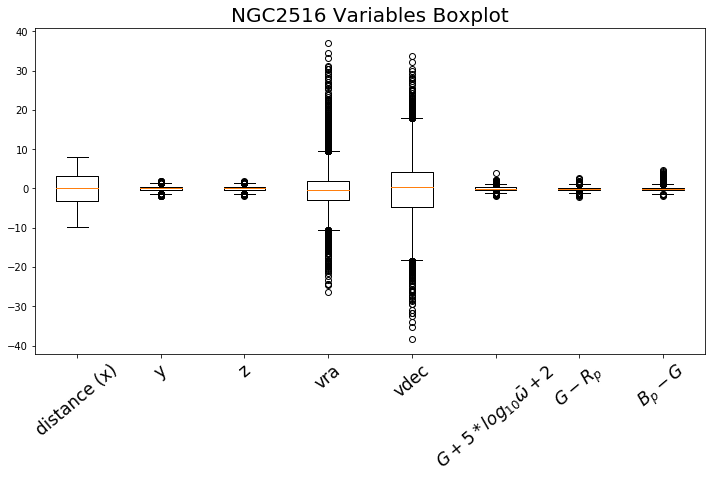

In [62]:
plt.figure(figsize=(12,6))
plt.title("%s Variables Boxplot"%source.name, fontsize=20)
plt.boxplot(dfnormcart)
plt.xticks(np.arange(len(gu.data_name_cart))+1, gu.data_name_cart, rotation = 40, fontsize = 17)
plt.show()

In [66]:
eps=0.6
min_samples=30
#source = tab_source[2]
ilabel_ = dbscan_labels(dfnormcart,eps, min_samples, all_labels=True, display=True)
#save_ilabel(source, ilabel, eps, min_samples)
#print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
#    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

## 1 clusters, size of the largest: 421  (on 11390 stars : 3.7%)
## Execution time : 1.5s


In [67]:
for i, ilabel in enumerate(ilabel_):
    #a = np.zeros(source.df.shape[0])
    #a[ilabel] = 1
    #ii = np.where(a==0)[0]
    #gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
    #gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
    print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

## 0, 421 stars, Dist : 413.5, Max Dist : 75.2 and 57.9


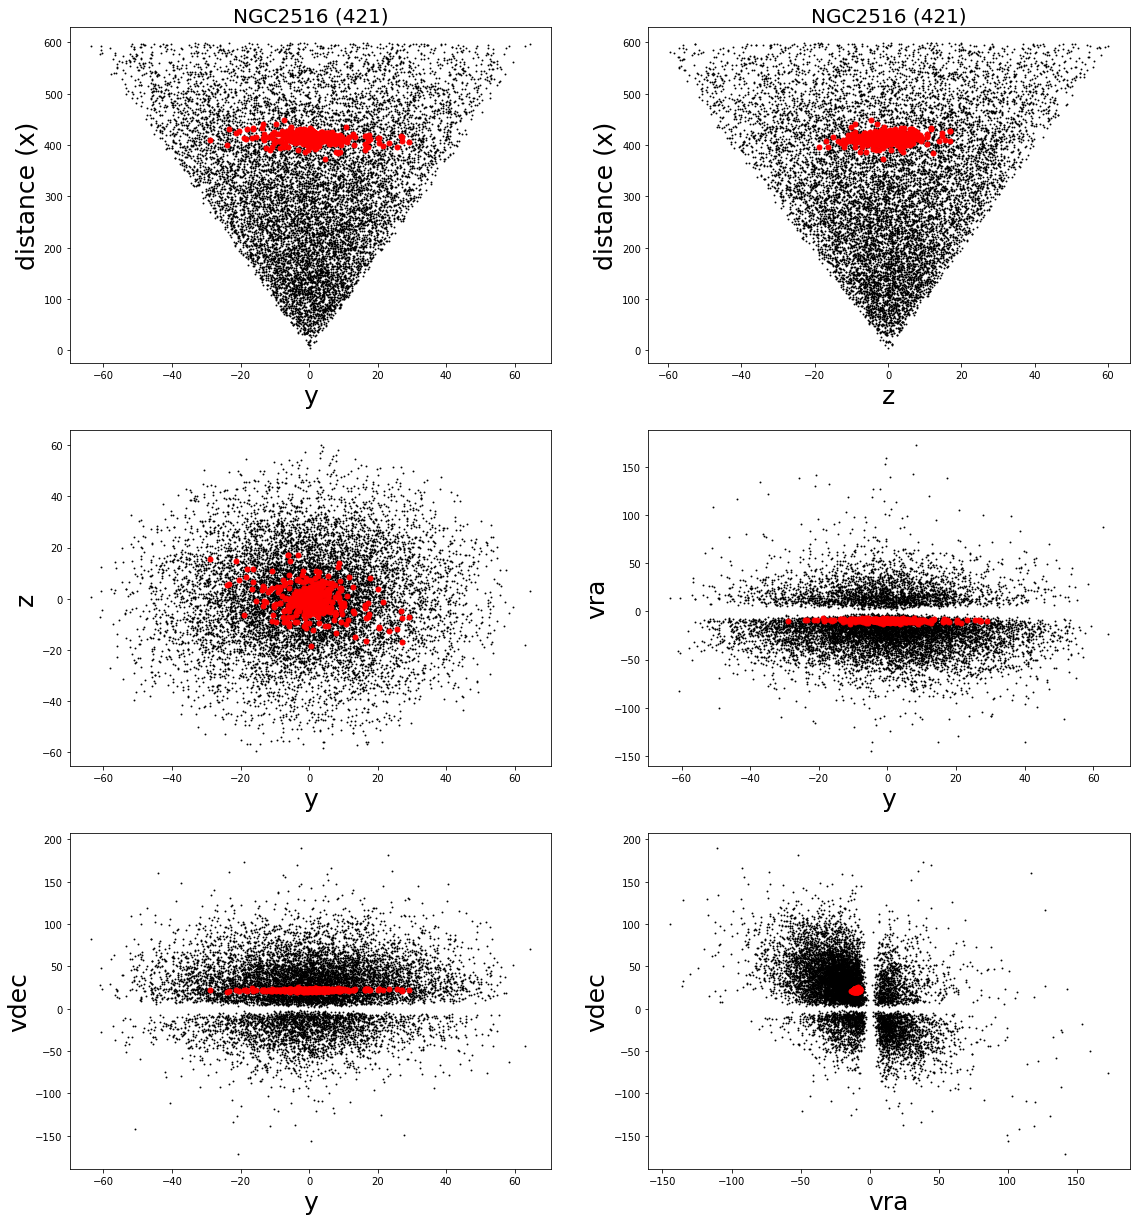

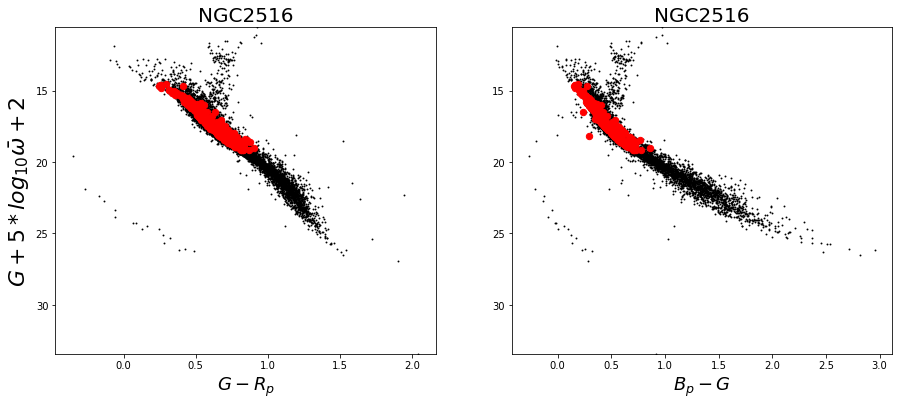

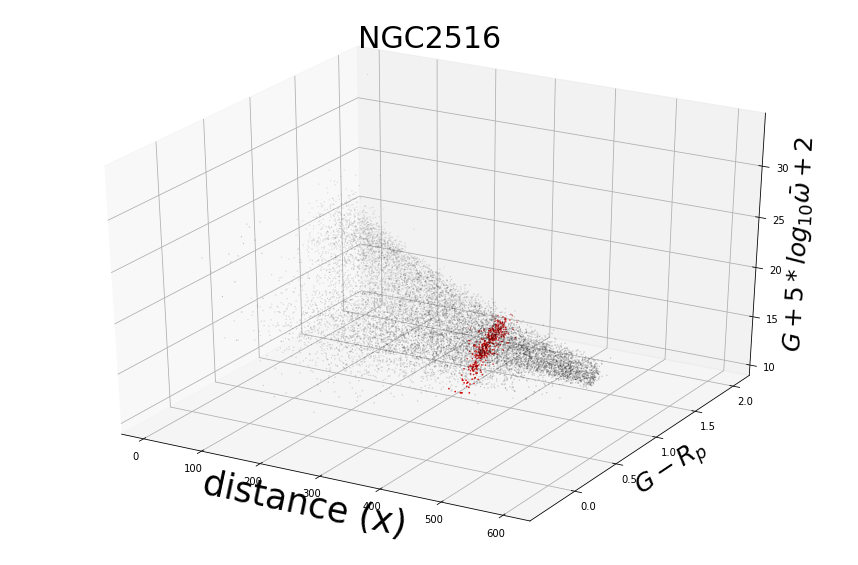

In [68]:
for ilabel in ilabel_ :
    #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
    source.plot_information(0.81,True, HRD=True, ilabel=ilabel)
    source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)

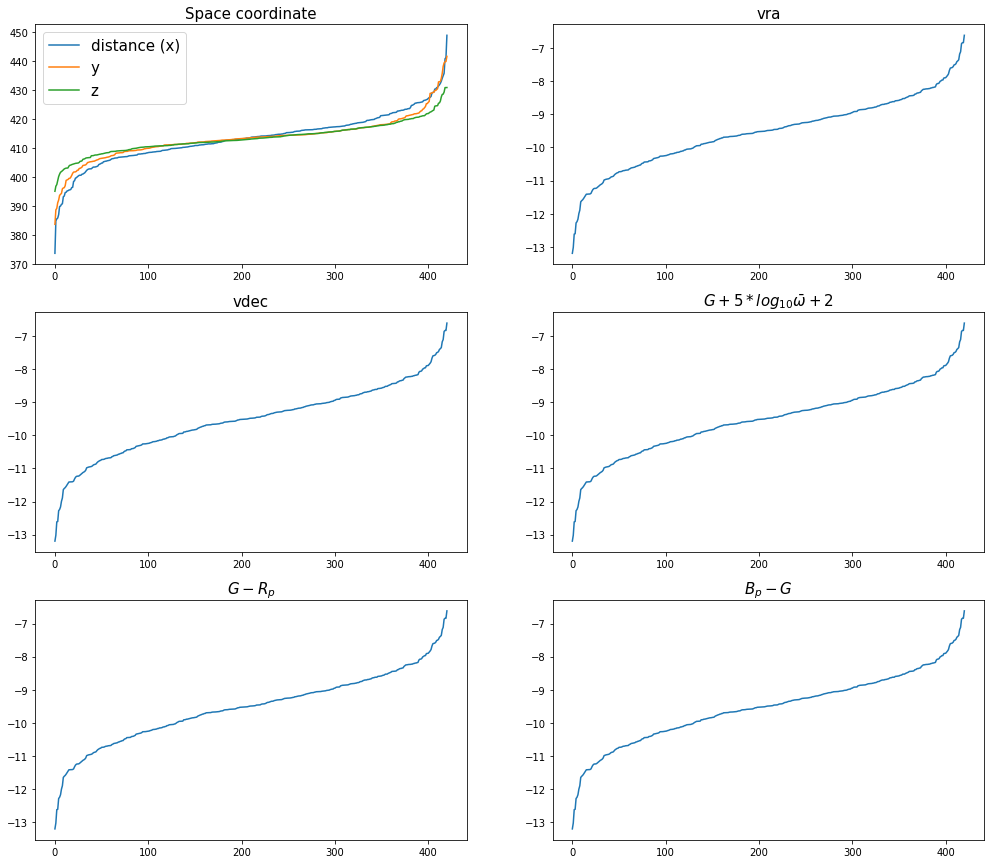

In [69]:
ilabel = ilabel_[0]
plt.figure(figsize=(17,15))
plt.subplot(321)
plt.title("Space coordinate", fontsize=15)
for i in range(3) :
    #plt.subplot(3,2,i+1)
    plt.plot(np.sort(source.dfcart[ilabel,i])-np.mean(source.dfcart[ilabel,i])+np.mean(source.dfcart[ilabel,0]), label=gu.data_name_cart[i])
    #plt.plot(np.zeros(len(np.sort(source.df[ilabel,3]))),c='r')
plt.legend(loc='best',fontsize=15)
for i in range(3,8) :
    plt.subplot(3,2,i-1)
    plt.title(gu.data_name_cart[i], fontsize=15)
    plt.plot(np.sort(source.df[ilabel,3]))
plt.show()

### ---------------------------------------------------------
# Ok loop

## 1 clusters, size of the largest: 421  (on 11390 stars : 3.7%)
## Execution time : 0.2s
## 0, 421 stars, Dist : 413.5, Max Dist : 75.2 and 57.9


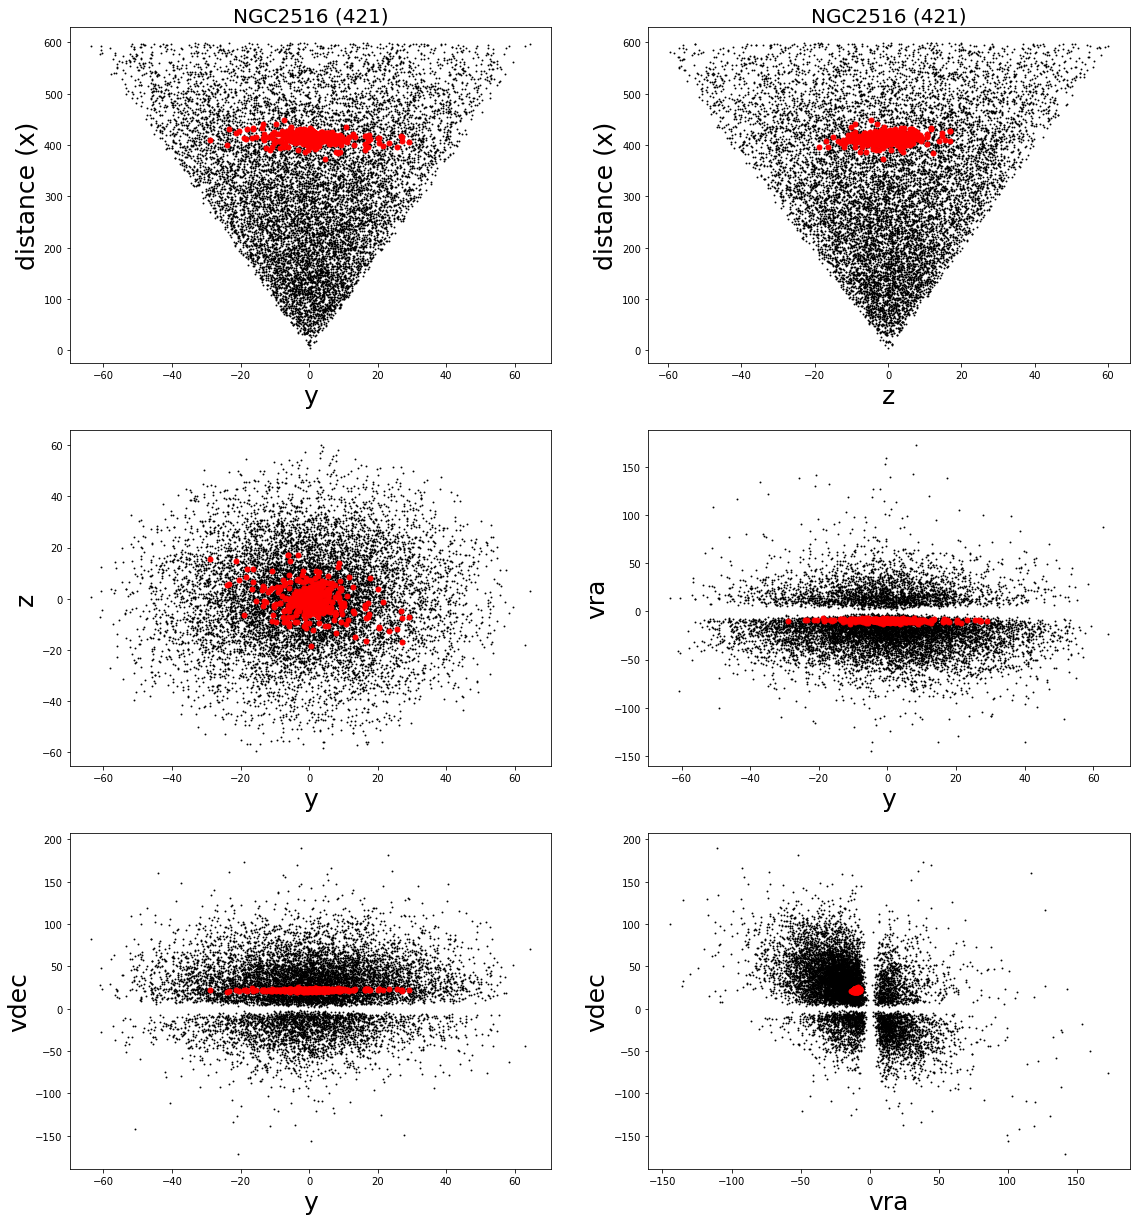

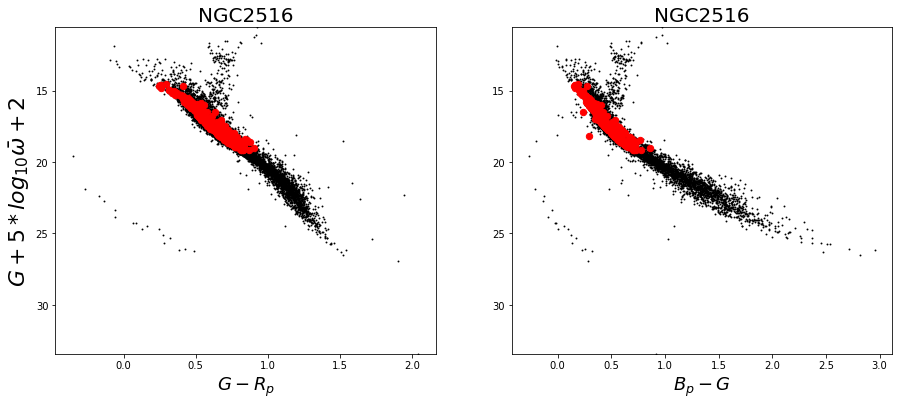

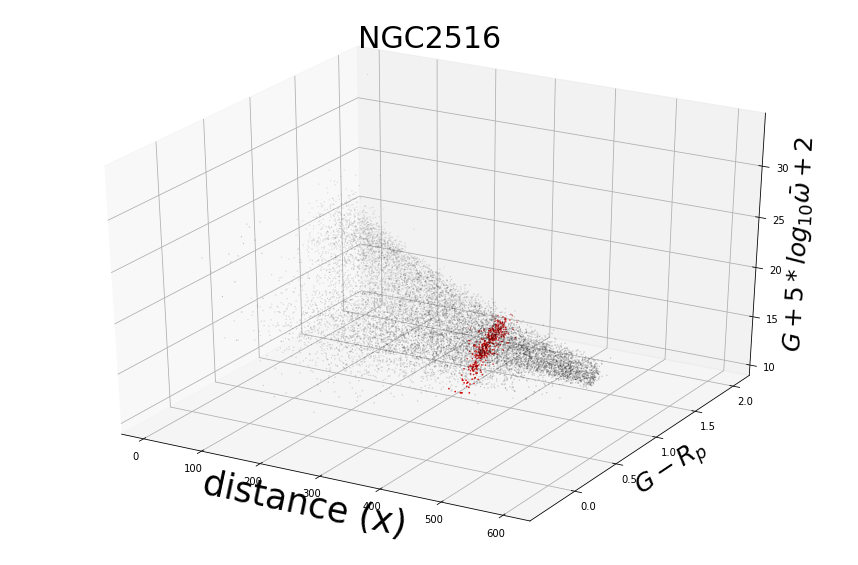

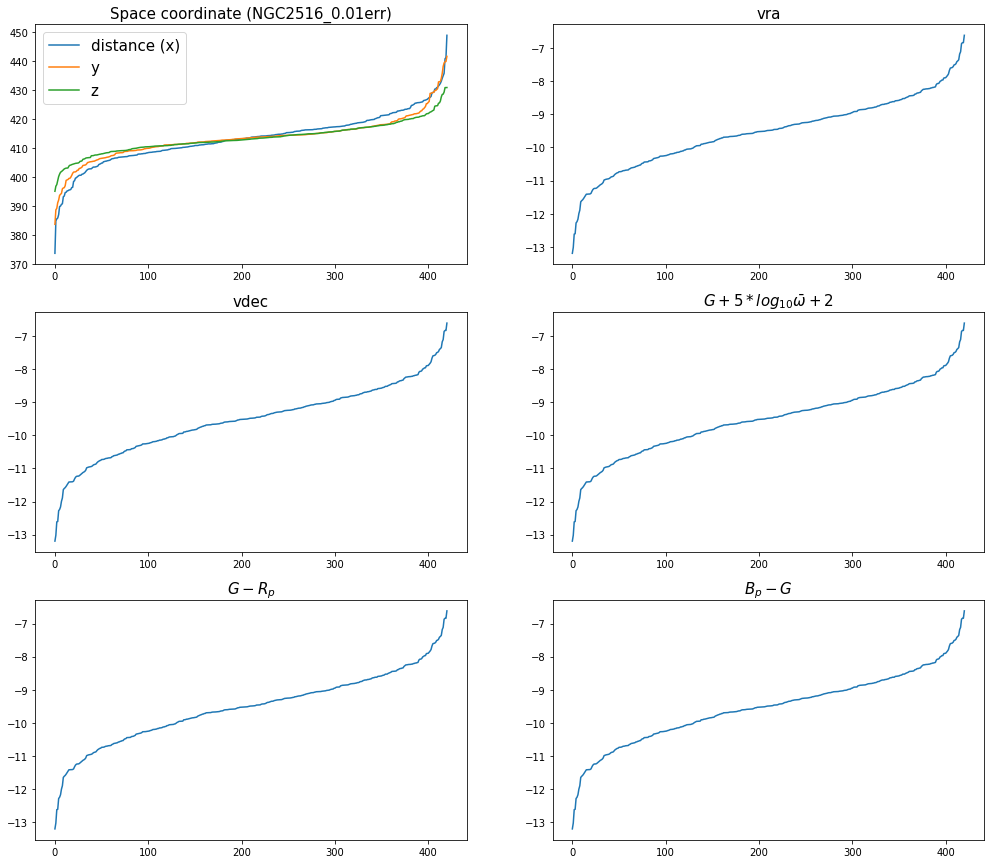

## 1 clusters, size of the largest: 999  (on 23830 stars : 4.2%)
## Execution time : 0.7s
## 0, 999 stars, Dist : 415.0, Max Dist : 79.7 and 60.3


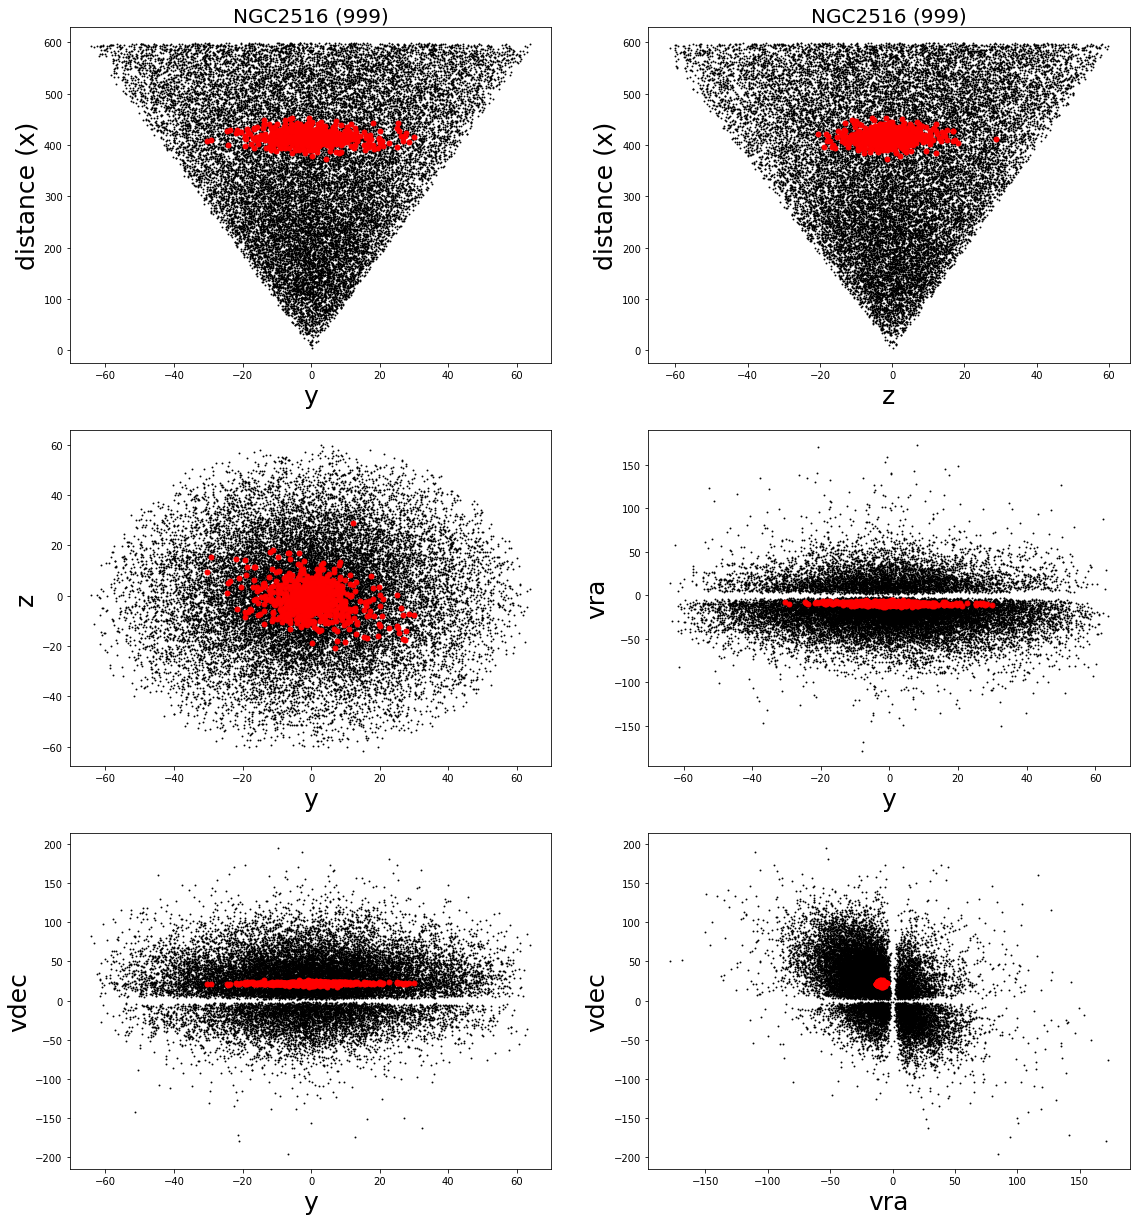

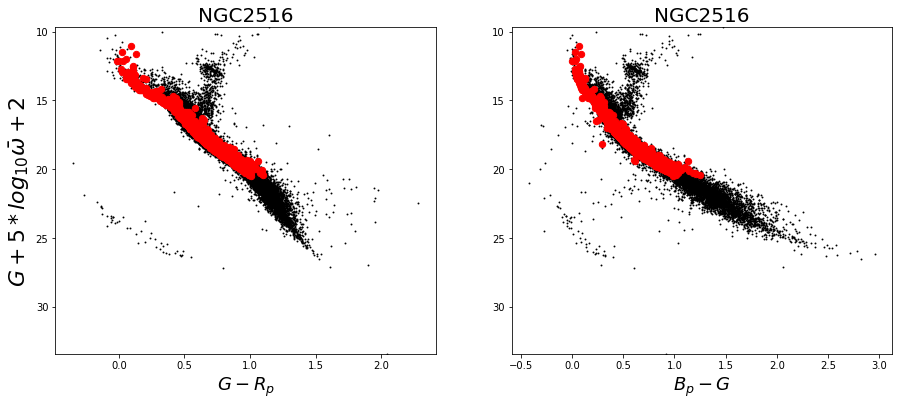

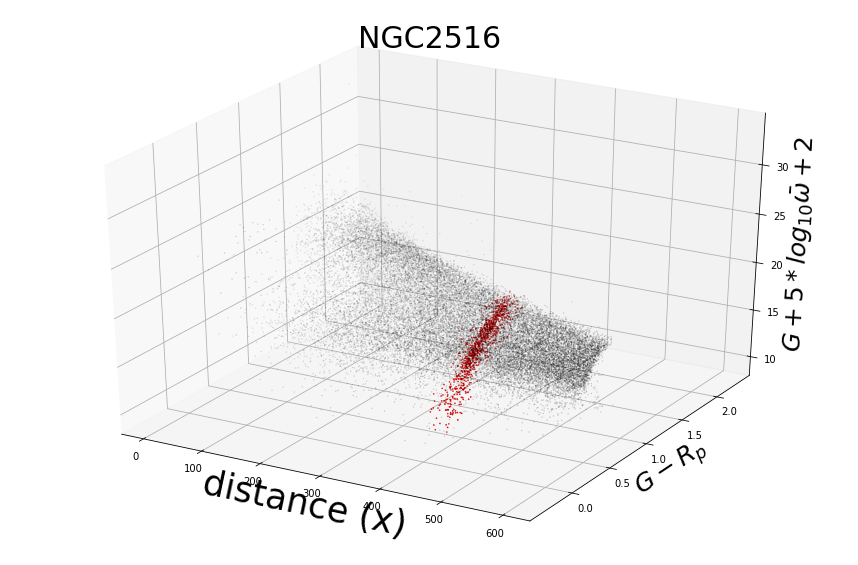

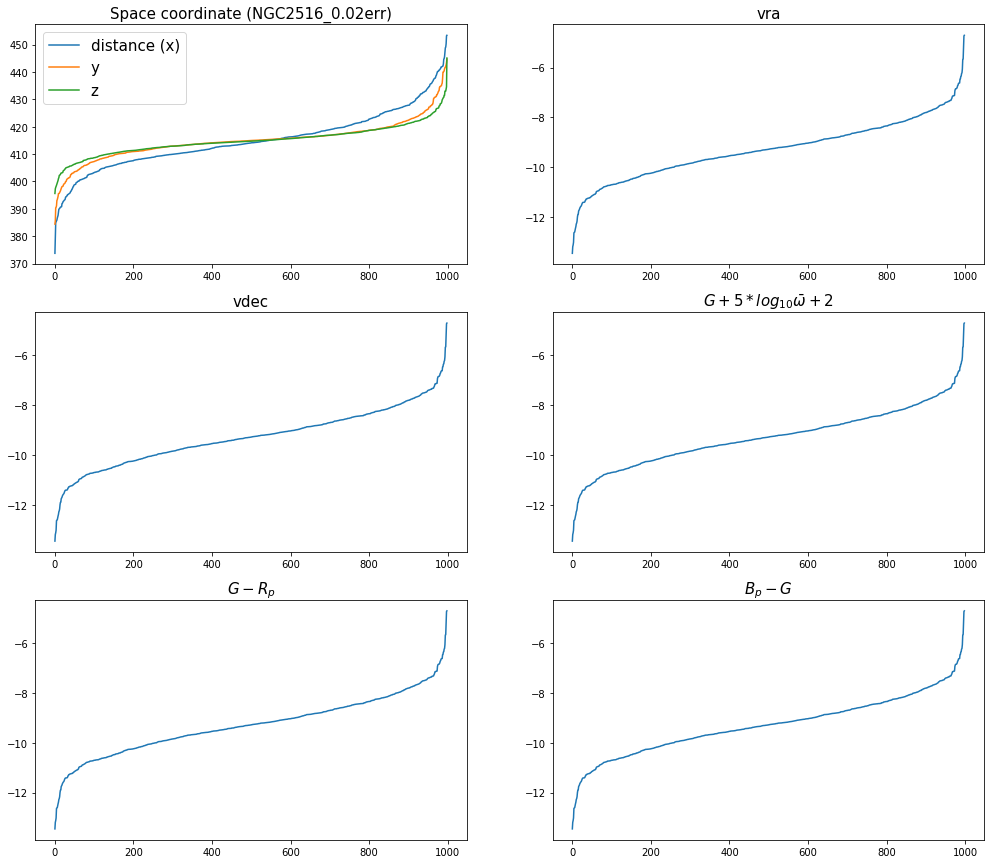

## 1 clusters, size of the largest: 1316  (on 30933 stars : 4.3%)
## Execution time : 1.0s
## 0, 1316 stars, Dist : 414.8, Max Dist : 79.7 and 60.3


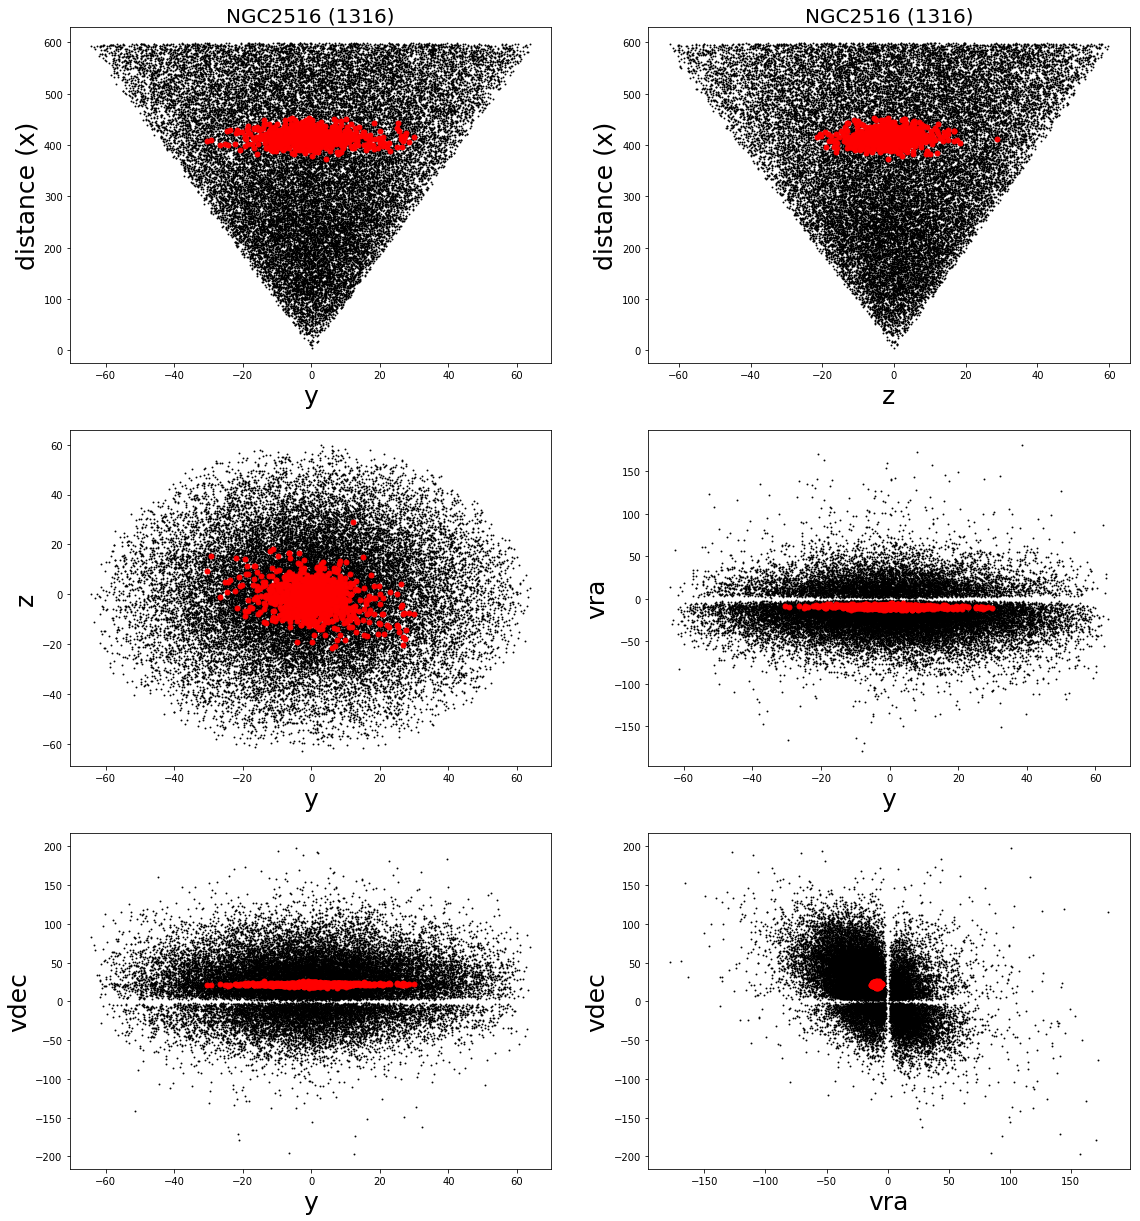

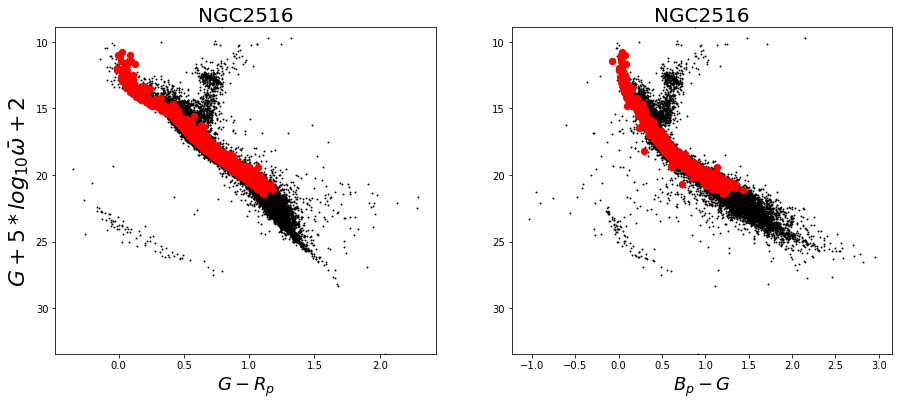

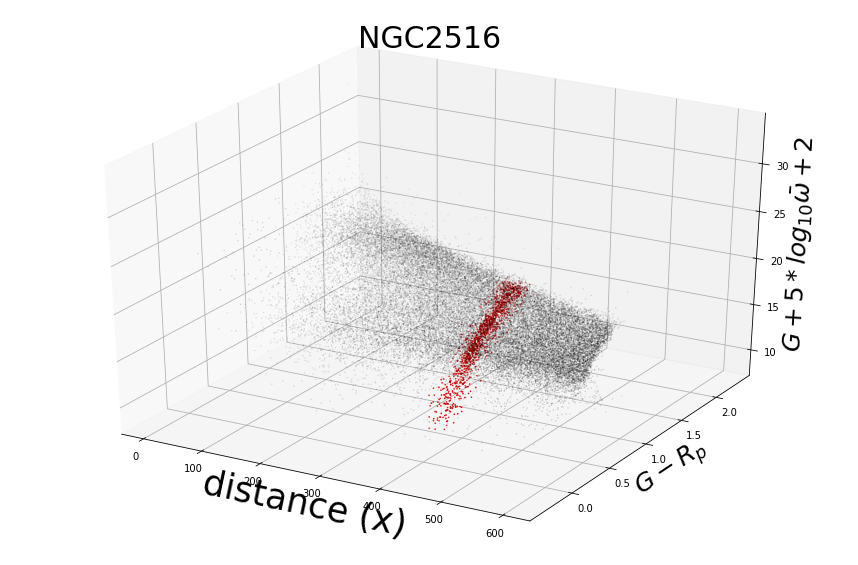

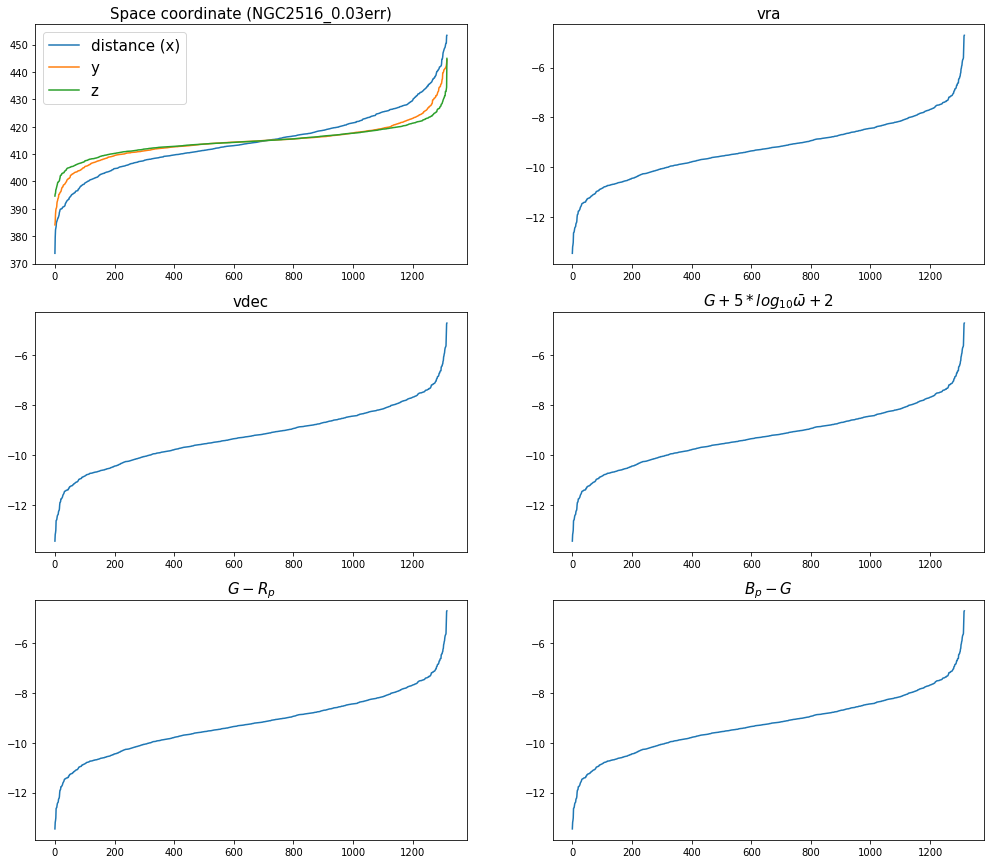

## 1 clusters, size of the largest: 3086  (on 78782 stars : 3.9%)
## Execution time : 3.5s
## 0, 3086 stars, Dist : 413.2, Max Dist : 179.1 and 64.8


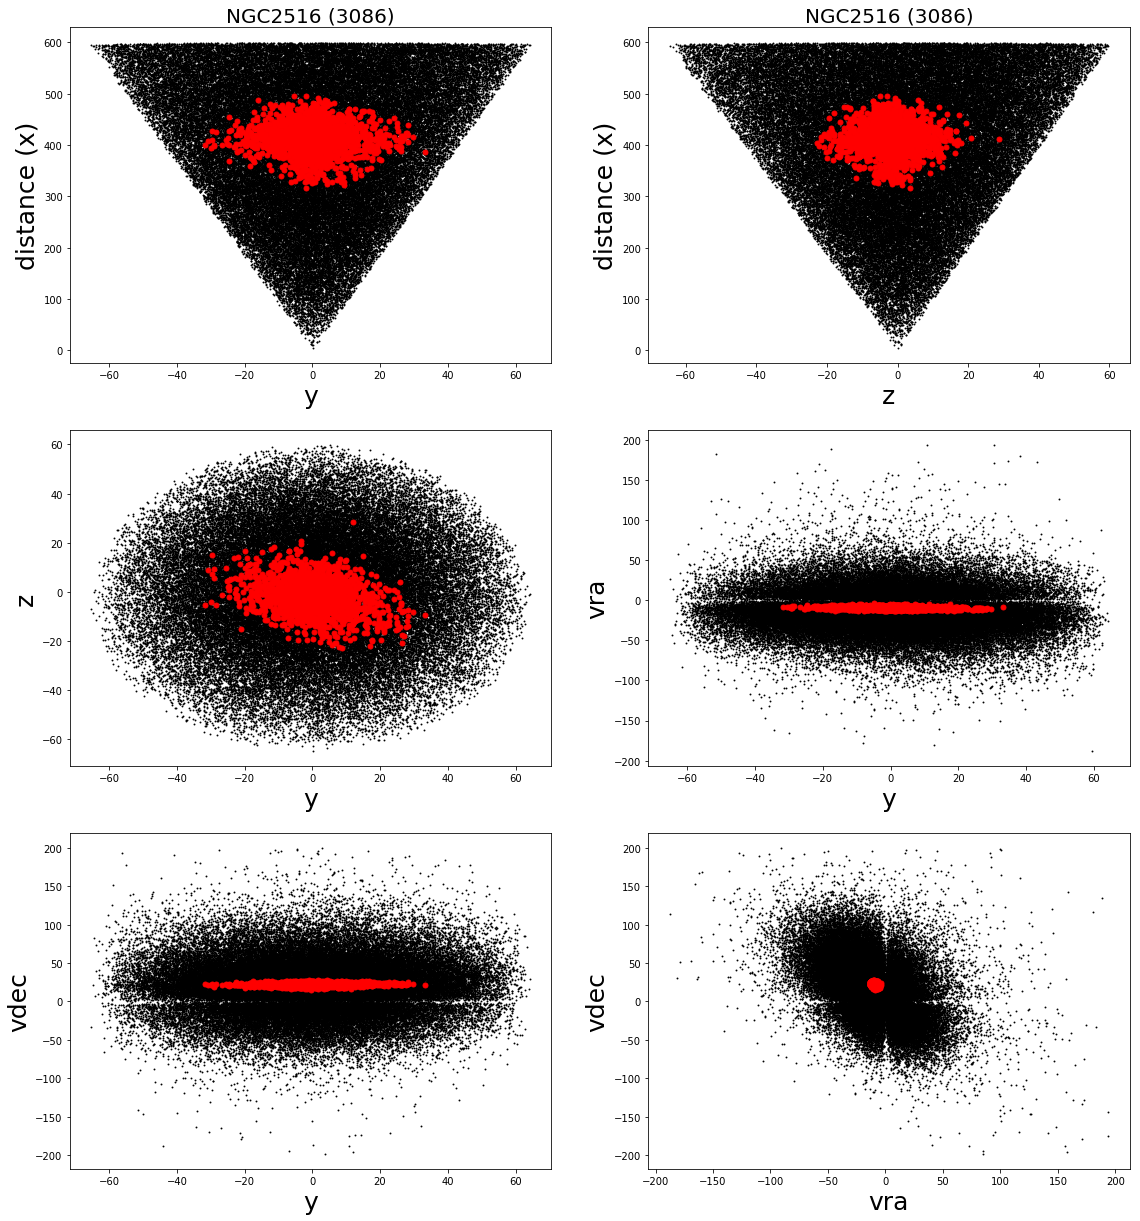

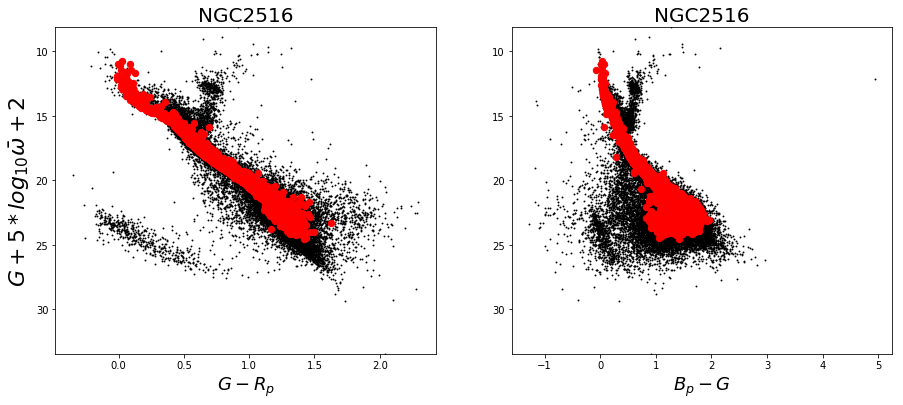

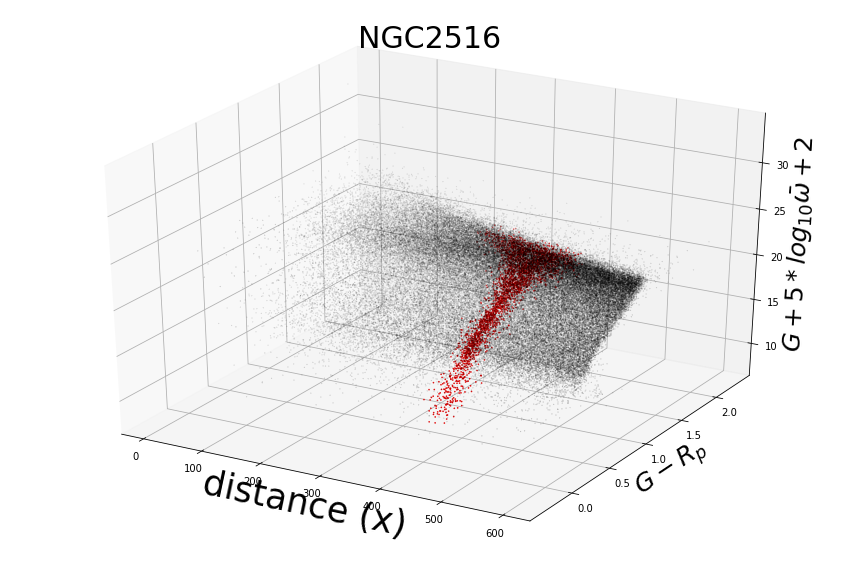

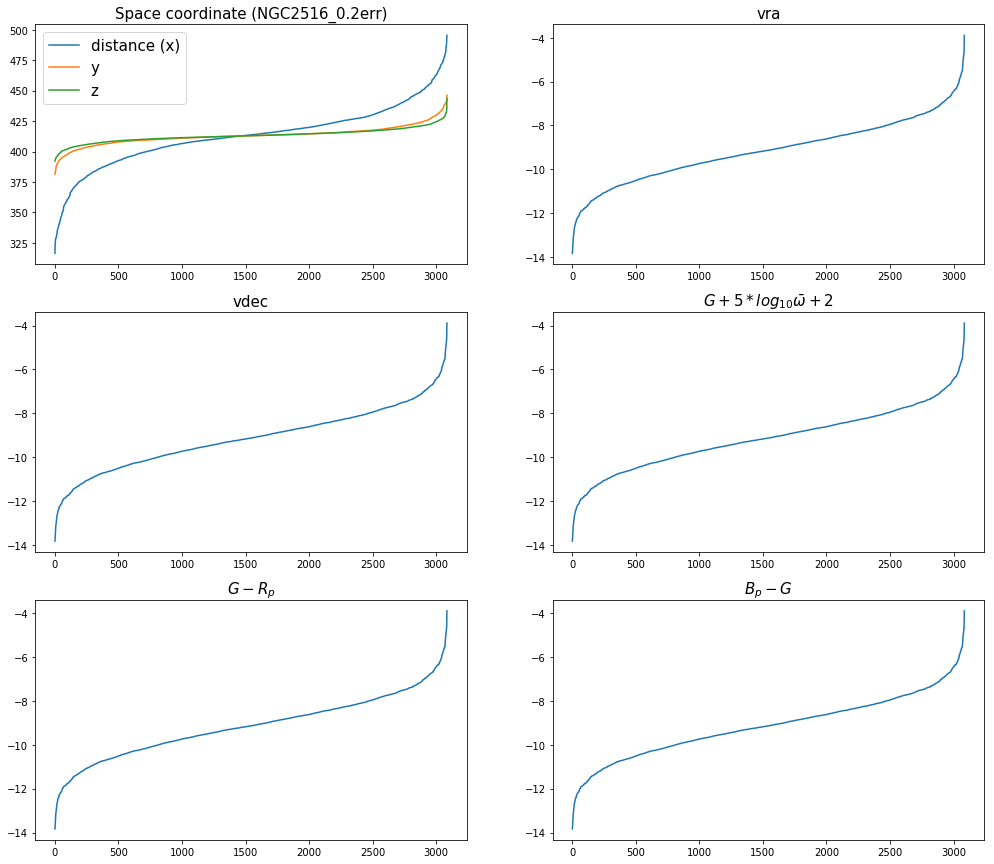

In [70]:
source = tab_source[0]
for source in tab_source :
    # Cartesian normalisation
    # x, y, z must have the same importance, the same for vdec and vra // R-G and 
    dfnormcart = np.zeros(source.df.shape)

    #weight  = [6*2000/source.distmax,2,2,4,4,4,4,4]
    weight_comp  = [0.03,0.2,0.25,2.]

    for i, j in zip(range(source.df.shape[1]),[0,0,0,1,1,2,3,3]) :
        dfnormcart[:,i] = weight_comp[j] * (source.dfcart[:,i] - np.mean(source.dfcart[:,i]))

    eps=0.6
    min_samples=30
    #source = tab_source[2]
    ilabel_ = dbscan_labels(dfnormcart,eps, min_samples, all_labels=True, display=True)
    #save_ilabel(source, ilabel, eps, min_samples)
    #print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
    #    np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

    for i, ilabel in enumerate(ilabel_):
        #a = np.zeros(source.df.shape[0])
        #a[ilabel] = 1
        #ii = np.where(a==0)[0]
        #gu.plot_information_cluster(source.dfcart[ii,:],size=0.01,cartesian=True)
        #gu.plot_information_cluster(source.dfcart,size=0.01,cartesian=True)
        print("## %d, %d stars, Dist : %.1f, Max Dist : %.1f and %.1f"%(i,len(ilabel),np.mean(source.df[ilabel,0]),
        np.max(source.df[ilabel,0])-np.min(source.df[ilabel,0]),np.max(source.dfcart[ilabel,1])-np.min(source.dfcart[ilabel,1])))

    for ilabel in ilabel_ :
        #source.plot_information(0.1,False, HRD=False, ilabel=ilabel)
        source.plot_information(0.81,True, HRD=True, ilabel=ilabel)
        source.plot_3D(0.01,True,(0,6,5),ilabel=ilabel)

    ilabel = ilabel_[0]
    plt.figure(figsize=(17,15))
    plt.subplot(321)
    plt.title("Space coordinate (%s_%serr)"%(source.name,source.errtol), fontsize=15)
    for i in range(3) :
        #plt.subplot(3,2,i+1)
        plt.plot(np.sort(source.dfcart[ilabel,i])-np.mean(source.dfcart[ilabel,i])+np.mean(source.dfcart[ilabel,0]), label=gu.data_name_cart[i])
        #plt.plot(np.zeros(len(np.sort(source.df[ilabel,3]))),c='r')
    plt.legend(loc='best',fontsize=15)
    for i in range(3,8) :
        plt.subplot(3,2,i-1)
        plt.title(gu.data_name_cart[i], fontsize=15)
        plt.plot(np.sort(source.df[ilabel,3]))
    plt.show()

### ------------------------------------------------

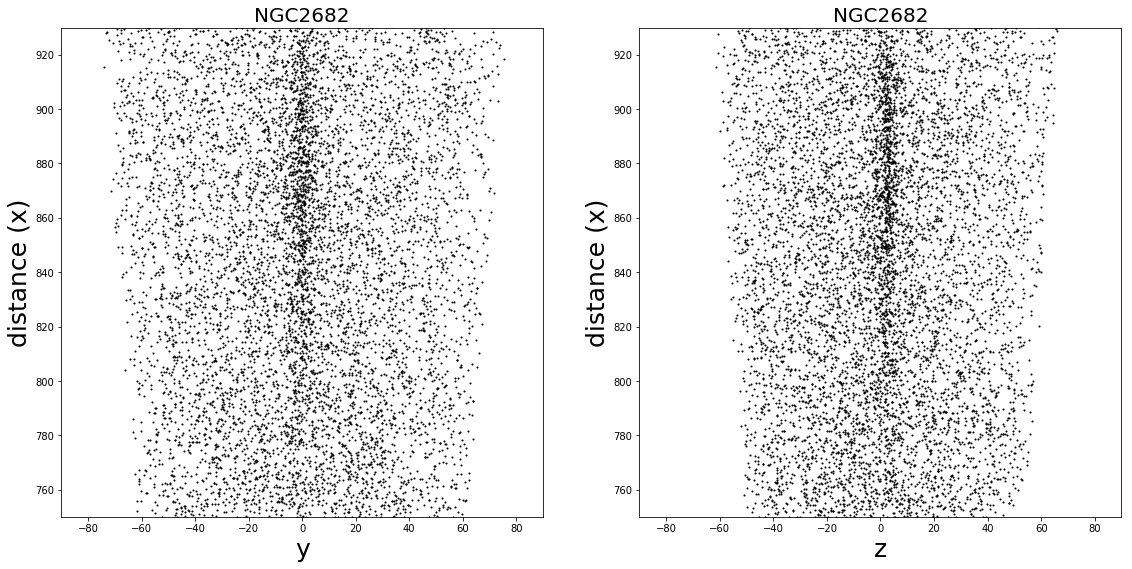

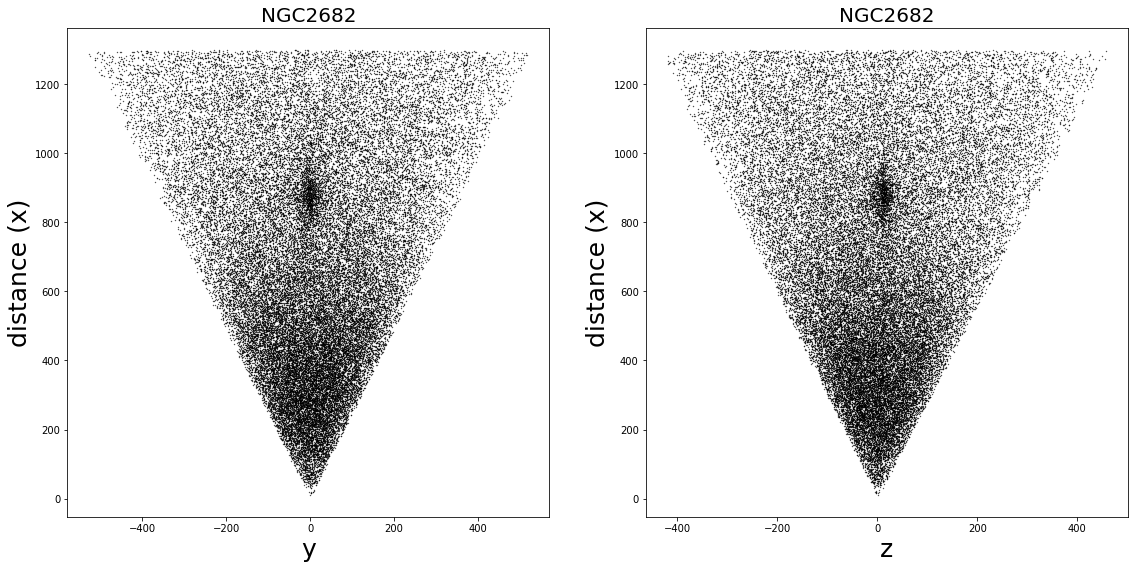

In [63]:
data = file_result[source.name]['data_cart']
#ilabel = ilabel_[0]
size = 1.1
center = 840

plt.figure(figsize=(19,9))                
for i_x, i_y, i in zip((1,2),(0,0),(1,2)) :
    plt.subplot(1,2,i)
    if i <= 2 : plt.title(source.name, fontsize=20)
    plt.scatter(source.dfcart[:,i_x],source.dfcart[:,i_y],s=size,c='k')
    #plt.scatter(data[:,i_x],data[:,i_y]/1.11260,s=size*30,c='r')
    plt.xlabel(gu.data_name_cart[i_x], fontsize=25)
    plt.ylabel(gu.data_name_cart[i_y], fontsize=25)
    plt.ylim(center-90,center+90)
    plt.xlim(-90,90)
    #plt.scatter(0,373,s=200,c='r')
plt.show()

plt.figure(figsize=(19,9))                
for i_x, i_y, i in zip((1,2),(0,0),(1,2)) :
    plt.subplot(1,2,i)
    if i <= 2 : plt.title(source.name, fontsize=20)
    plt.scatter(source.dfcart[:,i_x]*5,source.dfcart[:,i_y],s=0.1,c='k')
    #plt.scatter(data[:,i_x],data[:,i_y]/1.11260,s=size,c='w')
    plt.xlabel(gu.data_name_cart[i_x], fontsize=25)
    plt.ylabel(gu.data_name_cart[i_y], fontsize=25)
    #plt.ylim(center-60,center+60)
    #plt.xlim(-60,60)
    #plt.scatter(0,373,s=200,c='r')
plt.show()

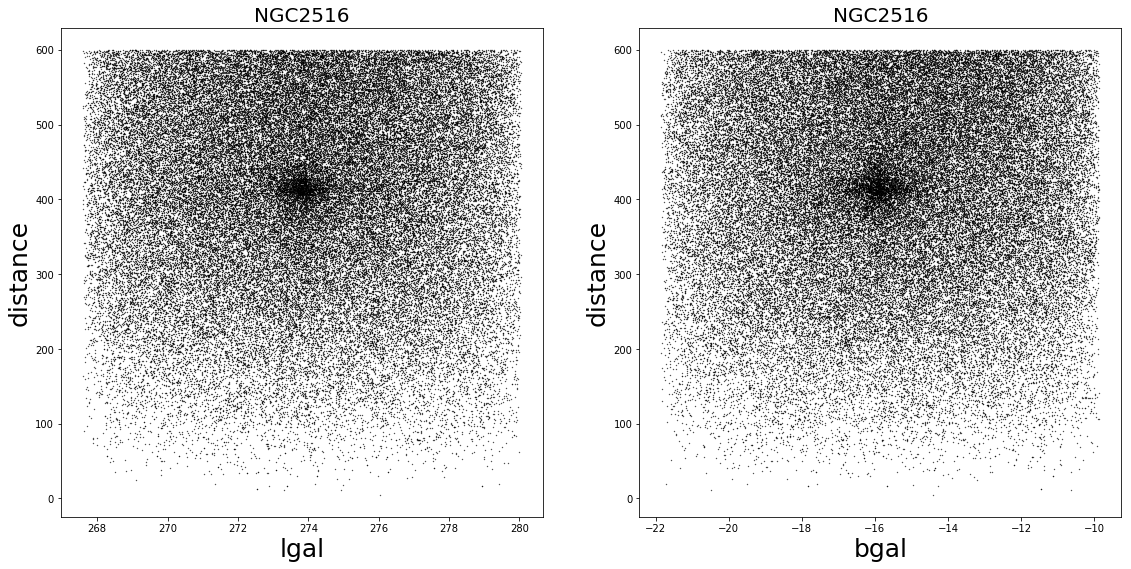

In [24]:
#ilabel = ilabel_[0]
size = 0.1

plt.figure(figsize=(19,9))                
for i_x, i_y, i in zip((1,2),(0,0),(1,2)) :
    plt.subplot(1,2,i)
    if i <= 2 : plt.title(source.name, fontsize=20)
    plt.scatter(source.df[:,i_x],source.df[:,i_y],s=size,c='k')
    #plt.scatter(source.dfcart[ilabel,i_x],source.dfcart[ilabel,i_y],s=size*300,c='r')
    plt.xlabel(gu.data_name[i_x], fontsize=25)
    plt.ylabel(gu.data_name[i_y], fontsize=25)
    #plt.ylim(350,470)
    #plt.xlim(-60,60)
plt.show()

In [28]:
a = np.arange(5)
b = np.array([2,2,2,2,2])
print(a*b)

[0 2 4 6 8]


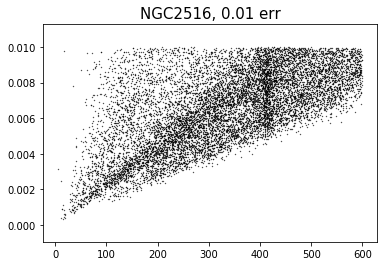

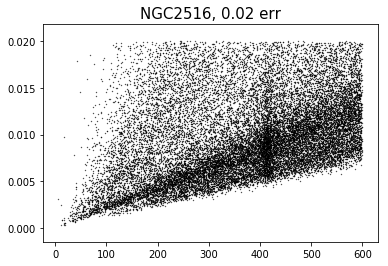

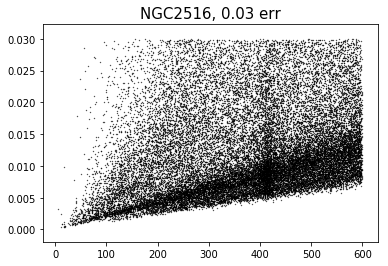

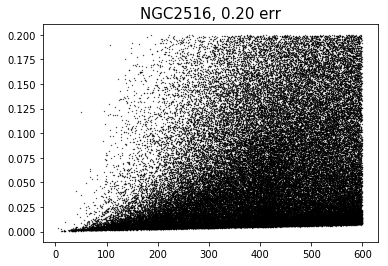

In [46]:
index = 1

for index in range(4) :

    ifinal = tab_source[index].unmasked
    parallax_err = np.array(tab_source[index].data['parallax_error'][ifinal])
    dist = tab_source[index].dfcart[:,0]
    dist_err = dist**2 * parallax_err / 1000


    #plt.scatter(dist,parallax_err/parallax,c='k',s=0.1)
    plt.title("%s, %.2f err"%(tab_source[index].name,tab_source[index].errtol),fontsize=15)
    plt.scatter(dist,dist_err/dist,c='k',s=0.1)
    #plt.yscale('log')
    plt.show()